# 03 – Modeling: Predicting High-Growth YouTube Videos

This notebook trains and evaluates machine learning models to predict whether a
YouTube video will become a **high-growth video** based on its early performance
metrics and Google Trends signals.

We use the final feature set produced in `02_feature_engineering.ipynb`, where
YouTube metadata has been merged with category-level Google Trends scores.


## 1. Imports

In [1]:
# 03_modeling.ipynb
# High-growth video prediction using YouTube and Google Trends features

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

plt.style.use("ggplot")

print("Modeling notebook ready.")

Modeling notebook ready.


## 2. Load Features With Google Trends

We load the processed feature set `features_with_trends.csv` from the
`../data/processed/` directory. This dataset already contains:

- YouTube video metrics (views, likes, comments, etc.)
- Engineered ratios (like/view, comment/view)
- Time-based features (publish hour, etc.)
- Category-level Google Trends scores and rolling averages


In [2]:
# Path to the final feature set (merged with Google Trends)
features_path = "../data/processed/features_with_trends.csv"

df = pd.read_csv(
    features_path,
    parse_dates=["trending_date", "publish_date"],
)

print("Features shape:", df.shape)
df.head()

Features shape: (34598, 17)


,video_id,trending_date,publish_date,publish_hour,views,likes,dislikes,comment_count,like_view_ratio,comment_view_ratio,view_growth,growth_rate,high_growth,category_id,trend_score,trend_score_3d_mean,trend_score_7d_mean
0,UFYCTJlayS4,2017-11-14,2017-11-11,3,52591,2233,187,255,0.042460,0.004849,3781.0,0.071894,0,1,0.0,0.0,0.0
1,fNtLIcyjsnI,2017-11-14,2017-11-09,17,1751064,16430,945,1231,0.009383,0.000703,245018.0,0.139925,1,1,0.0,0.0,0.0
2,jr9QtXwC9vc,2017-11-14,2017-11-13,14,826059,3543,119,340,0.004289,0.000412,1845697.0,2.234340,1,1,0.0,0.0,0.0
3,kOnQocd799Y,2017-11-14,2017-11-09,17,2736733,58967,3492,7915,0.021546,0.002892,107538.0,0.039294,0,1,0.0,0.0,0.0
4,n30k5CwLhS4,2017-11-14,2011-05-29,17,50867,715,238,246,0.014056,0.004836,7602.0,0.149449,1,1,0.0,0.0,0.0


## 3. Feature Selection and Missing Value Handling

We define the list of features used for modeling. Note that we intentionally
exclude future-dependent variables such as `view_growth` or `growth_rate` from
the input features to avoid data leakage.

Since Google Trends data is merged with a left join, some rows may not have a
trend value. To ensure the models can be trained, we impute missing numeric
values with the **median** of each feature.


In [3]:
# Inspect distribution of the target variable
print("High-growth label distribution (fraction):")
print(df["high_growth"].value_counts(normalize=True))

# Features to be used in the models
feature_cols = [
    "views",
    "likes",
    "dislikes",
    "comment_count",
    "like_view_ratio",
    "comment_view_ratio",
    "publish_hour",
    "category_id",
    "trend_score",
    "trend_score_3d_mean",
    "trend_score_7d_mean",
]

# Check for missing values
print("\nNumber of NaNs per feature before imputation:")
print(df[feature_cols].isna().sum())

# Simple and robust imputation strategy:
# - numeric features -> median
# - non-numeric features (if any) -> -1 as a dummy category
for col in feature_cols:
    if df[col].dtype.kind in "iuf":  # int/unsigned/float
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(-1)

print("\nNumber of NaNs per feature after imputation:")
print(df[feature_cols].isna().sum())

X = df[feature_cols].copy()
y = df["high_growth"].astype(int)

X.head()

High-growth label distribution (fraction):
high_growth
0    0.749986
1    0.250014
Name: proportion, dtype: float64

Number of NaNs per feature before imputation:
views                     0
likes                     0
dislikes                  0
comment_count             0
like_view_ratio           0
comment_view_ratio        0
publish_hour              0
category_id               0
trend_score            1189
trend_score_3d_mean    1189
trend_score_7d_mean    1189
dtype: int64

Number of NaNs per feature after imputation:
views                  0
likes                  0
dislikes               0
comment_count          0
like_view_ratio        0
comment_view_ratio     0
publish_hour           0
category_id            0
trend_score            0
trend_score_3d_mean    0
trend_score_7d_mean    0
dtype: int64


,views,likes,dislikes,comment_count,like_view_ratio,comment_view_ratio,publish_hour,category_id,trend_score,trend_score_3d_mean,trend_score_7d_mean
0,52591,2233,187,255,0.042460,0.004849,3,1,0.0,0.0,0.0
1,1751064,16430,945,1231,0.009383,0.000703,17,1,0.0,0.0,0.0
2,826059,3543,119,340,0.004289,0.000412,14,1,0.0,0.0,0.0
3,2736733,58967,3492,7915,0.021546,0.002892,17,1,0.0,0.0,0.0
4,50867,715,238,246,0.014056,0.004836,17,1,0.0,0.0,0.0


## 4. Time-Based Train / Validation / Test Split

Instead of using a random split, we respect the temporal nature of the data:

- The dataset is sorted by `trending_date`.
- The oldest **60%** of the rows are used for **training**.
- The next **20%** are reserved for **validation** (not explicitly tuned here,
  but could be used for hyperparameter search).
- The most recent **20%** are used for **testing**.

This setup mimics a realistic scenario: we train models on past data and
evaluate them on future videos.


In [4]:
# Time-based train/validation/test split
df_sorted = df.sort_values("trending_date").reset_index(drop=True)

n = len(df_sorted)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train = df_sorted.iloc[:train_end]
val = df_sorted.iloc[train_end:val_end]
test = df_sorted.iloc[val_end:]

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

X_train = train[feature_cols]
y_train = train["high_growth"].astype(int)

X_val = val[feature_cols]
y_val = val["high_growth"].astype(int)

X_test = test[feature_cols]
y_test = test["high_growth"].astype(int)

print("\nLabel distribution (train, val, test):")
print(y_train.value_counts(normalize=True), 
      y_val.value_counts(normalize=True), 
      y_test.value_counts(normalize=True))

Train: 20758, Val: 6920, Test: 6920

Label distribution (train, val, test):
high_growth
0    0.68629
1    0.31371
Name: proportion, dtype: float64 high_growth
0    0.832514
1    0.167486
Name: proportion, dtype: float64 high_growth
0    0.858526
1    0.141474
Name: proportion, dtype: float64


## 5. Models and Evaluation Metrics

We evaluate several supervised classification models:

1. **Logistic Regression** – a simple linear baseline.
2. **Random Forest** – a non-linear ensemble model.
3. **XGBoost** – a gradient boosting model, strong on tabular data.
4. **LightGBM** – a fast gradient boosting model optimized for large and sparse features.

For each model we report:

- **Accuracy**
- **F1-score**
- **ROC-AUC**
- A full classification report (precision, recall, F1 per class).


In [5]:
def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, name="Model"):
    """Prints basic evaluation metrics and returns them in a dictionary."""
    y_pred = model.predict(X_te)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
        roc = roc_auc_score(y_te, y_proba)
    else:
        y_scores = model.decision_function(X_te)
        roc = roc_auc_score(y_te, y_scores)

    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)

    print(f"\n==== {name} ====")
    print("Accuracy:", acc)
    print("F1-score:", f1)
    print("ROC-AUC:", roc)
    print("\nClassification report:\n", classification_report(y_te, y_pred))

    return {"accuracy": acc, "f1": f1, "roc_auc": roc}

In [6]:
# Baseline model: Logistic Regression
log_reg = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
)

log_reg.fit(X_train, y_train)

metrics_lr = evaluate_classifier(
    log_reg, X_train, y_train, X_test, y_test, name="Logistic Regression"
)


==== Logistic Regression ====
Accuracy: 0.8573699421965318
F1-score: 0.08186046511627906
ROC-AUC: 0.6328030020774593

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      5941
           1       0.46      0.04      0.08       979

    accuracy                           0.86      6920
   macro avg       0.66      0.52      0.50      6920
weighted avg       0.81      0.86      0.80      6920



In [7]:
# Non-linear model: Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

metrics_rf = evaluate_classifier(
    rf, X_train, y_train, X_test, y_test, name="Random Forest"
)


==== Random Forest ====
Accuracy: 0.8027456647398844
F1-score: 0.26652337452982267
ROC-AUC: 0.6223021440487572

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89      5941
           1       0.28      0.25      0.27       979

    accuracy                           0.80      6920
   macro avg       0.58      0.57      0.58      6920
weighted avg       0.79      0.80      0.80      6920



In [8]:
# XGBoost Classifier
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42,
)

xgb.fit(X_train, y_train)

metrics_xgb = evaluate_classifier(
    xgb, X_train, y_train, X_test, y_test, name="XGBoost"
)

metrics_xgb



==== XGBoost ====
Accuracy: 0.8163294797687861
F1-score: 0.22922983626440266
ROC-AUC: 0.6285606557777285

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      5941
           1       0.28      0.19      0.23       979

    accuracy                           0.82      6920
   macro avg       0.58      0.56      0.56      6920
weighted avg       0.79      0.82      0.80      6920



{'accuracy': 0.8163294797687861,
 'f1': 0.22922983626440266,
 'roc_auc': 0.6285606557777285}

### 5.1 LightGBM Classifier

As another gradient boosting approach, we train a **LightGBM** classifier on the same
feature set. LightGBM is designed for speed and can handle large, sparse feature
spaces efficiently.

In [9]:
# Gradient boosting model: LightGBM
lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary",
    random_state=42,
    n_jobs=-1,
)

lgbm.fit(X_train, y_train)

metrics_lgbm = evaluate_classifier(
    lgbm, X_train, y_train, X_test, y_test, name="LightGBM"
)

metrics_lgbm

[LightGBM] [Info] Number of positive: 6512, number of negative: 14246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2128
[LightGBM] [Info] Number of data points in the train set: 20758, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.313710 -> initscore=-0.782830
[LightGBM] [Info] Start training from score -0.782830

==== LightGBM ====
Accuracy: 0.8163294797687861
F1-score: 0.2254722730042657
ROC-AUC: 0.6280869819826868

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      5941
           1       0.28      0.19      0.23       979

    accuracy                           0.82      6920
   macro avg       0.58      0.55      0.56      6920
weighted avg       0.79      0.82      0

{'accuracy': 0.8163294797687861,
 'f1': 0.2254722730042657,
 'roc_auc': 0.6280869819826868}

### 5.2 ROC Curves for All Models

To compare discriminative performance across models, we plot ROC curves on the
same test set for:

- Logistic Regression
- Random Forest
- XGBoost
- LightGBM

This allows us to visually inspect which model better separates high-growth from
non–high-growth videos at different classification thresholds.

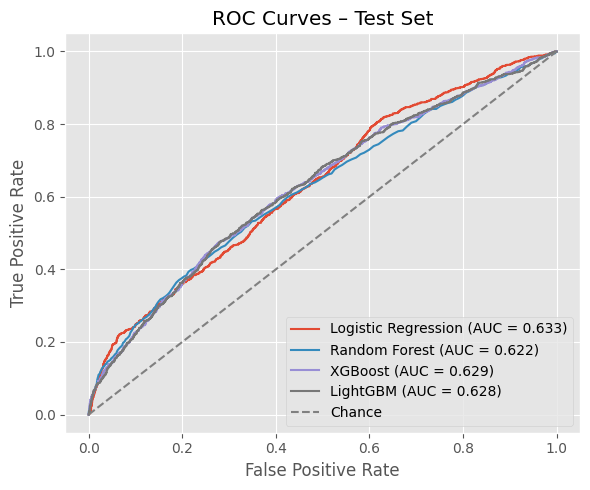

In [10]:
# ROC curves for all models on the test set
models_for_roc = [
    ("Logistic Regression", log_reg),
    ("Random Forest", rf),
    ("XGBoost", xgb),
    ("LightGBM", lgbm),
]

fig, ax = plt.subplots(figsize=(6, 5))

for name, model in models_for_roc:
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

ax.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Chance")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves – Test Set")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 6. Confusion Matrices and Feature Importances (Tree-Based Models)

Tree-based ensemble models such as Random Forest, XGBoost, and LightGBM
often perform better when there are non-linear relationships and interactions
between features.

In this section we inspect:

- The confusion matrices on the test set.
- Feature importances estimated by each tree-based model.

This helps us understand which signals (e.g., early views, engagement ratios,
Google Trends scores) contribute the most to predicting high-growth videos.

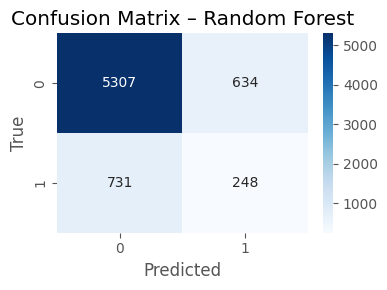

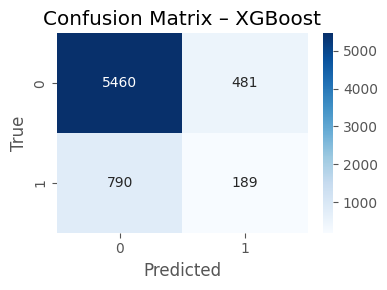

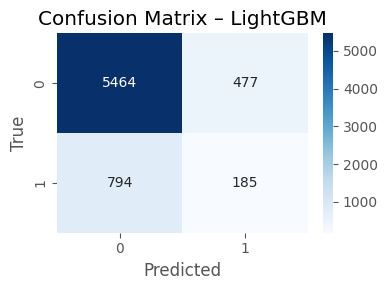

In [11]:
# Confusion matrices for tree-based models
tree_models = [
    ("Random Forest", rf),
    ("XGBoost", xgb),
    ("LightGBM", lgbm),
]

for name, model in tree_models:
    cm = confusion_matrix(y_test, model.predict(X_test))

    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix – {name}")
    plt.tight_layout()
    plt.show()

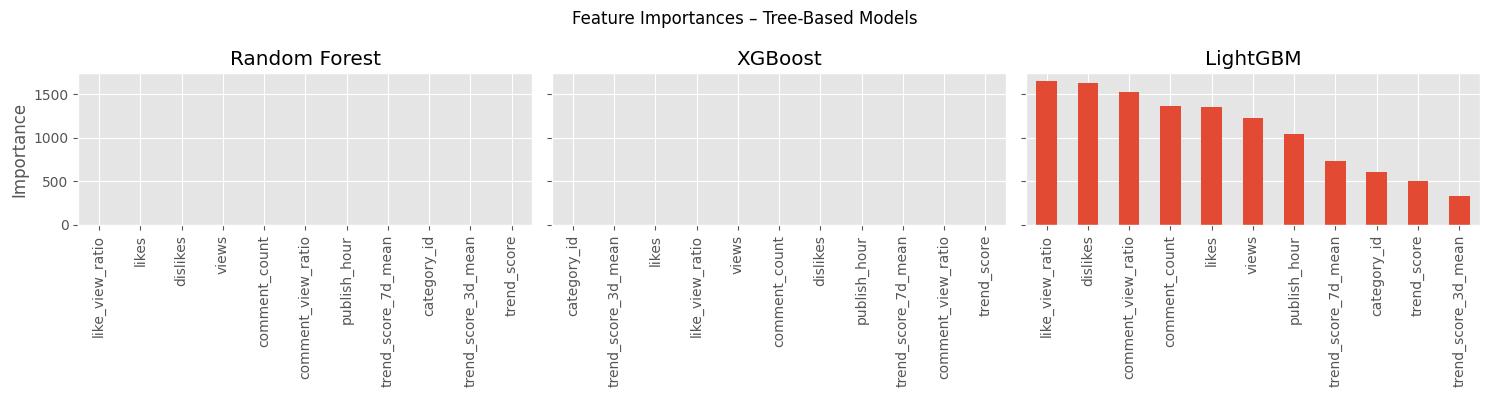

like_view_ratio        1659
dislikes               1628
comment_view_ratio     1533
comment_count          1361
likes                  1357
views                  1234
publish_hour           1047
trend_score_7d_mean     733
category_id             610
trend_score             501
trend_score_3d_mean     337
dtype: int32

In [12]:
# Feature importances for tree-based models
tree_models = [
    ("Random Forest", rf),
    ("XGBoost", xgb),
    ("LightGBM", lgbm),
]

fig, axes = plt.subplots(1, len(tree_models), figsize=(5 * len(tree_models), 4), sharey=True)

for ax, (name, model) in zip(axes, tree_models):
    importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
    importances.plot(kind="bar", ax=ax)
    ax.set_title(name)
    ax.set_ylabel("Importance")
    ax.tick_params(axis="x", labelrotation=90)

plt.suptitle("Feature Importances – Tree-Based Models")
plt.tight_layout()
plt.show()

importances

### 6.1 Optional: Hyperparameter Tuning for XGBoost

As an optional step, we can perform a small hyperparameter search for XGBoost
using `GridSearchCV`. The grid below contains 16 combinations (2×2×2×2), which
is enough to see whether tuning materially improves ROC-AUC without taking too
much time.

In [13]:
# Small hyperparameter search for XGBoost (optional)
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
}

xgb_base = XGBClassifier(
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

xgb_tuned = grid.best_estimator_

metrics_xgb_tuned = evaluate_classifier(
    xgb_tuned, X_train, y_train, X_test, y_test, name="XGBoost (tuned)"
)

metrics_xgb_tuned

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Best CV ROC-AUC: 0.6474066294282509

==== XGBoost (tuned) ====
Accuracy: 0.846820809248555
F1-score: 0.2077727952167414
ROC-AUC: 0.6462555097890578

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92      5941
           1       0.39      0.14      0.21       979

    accuracy                           0.85      6920
   macro avg       0.63      0.55      0.56      6920
weighted avg       0.80      0.85      0.82      6920



{'accuracy': 0.846820809248555,
 'f1': 0.2077727952167414,
 'roc_auc': 0.6462555097890578}

## 7. Impact of Google Trends Features

To quantify the added value of Google Trends, we compare two Random Forest models:

- **RF WITHOUT Trends**: trained on YouTube features only  
  (`views`, `likes`, `comment_view_ratio`, `publish_hour`, `category_id`, etc.).

- **RF WITH Trends**: trained on the full feature set, including  
  `trend_score`, `trend_score_3d_mean`, `trend_score_7d_mean`.

By comparing their Accuracy, F1-score, and ROC-AUC on the same test set, we can
assess whether Google Trends provides additional predictive power.


In [14]:
# Trend-related columns
trend_cols = ["trend_score", "trend_score_3d_mean", "trend_score_7d_mean"]

base_features = [c for c in feature_cols if c not in trend_cols]
trend_features = feature_cols  # all features


def train_eval_rf(feature_list, name=""):
    X_train_f = train[feature_list]
    X_test_f = test[feature_list]
    y_train_f = train["high_growth"].astype(int)
    y_test_f = test["high_growth"].astype(int)

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train_f, y_train_f)

    y_pred = model.predict(X_test_f)
    y_proba = model.predict_proba(X_test_f)[:, 1]

    acc = accuracy_score(y_test_f, y_pred)
    f1 = f1_score(y_test_f, y_pred)
    roc = roc_auc_score(y_test_f, y_proba)

    print(f"\n==== {name} ====")
    print("Accuracy:", acc)
    print("F1:", f1)
    print("ROC-AUC:", roc)

    return {"accuracy": acc, "f1": f1, "roc_auc": roc}


metrics_rf_no_trend = train_eval_rf(base_features, name="RF WITHOUT Trends")
metrics_rf_with_trend = train_eval_rf(trend_features, name="RF WITH Trends")

summary = pd.DataFrame(
    {
        "model": ["RF_without_trends", "RF_with_trends"],
        "accuracy": [metrics_rf_no_trend["accuracy"], metrics_rf_with_trend["accuracy"]],
        "f1": [metrics_rf_no_trend["f1"], metrics_rf_with_trend["f1"]],
        "roc_auc": [metrics_rf_no_trend["roc_auc"], metrics_rf_with_trend["roc_auc"]],
    }
)

summary


==== RF WITHOUT Trends ====
Accuracy: 0.7601156069364162
F1: 0.28262748487467587
ROC-AUC: 0.6257583293946484

==== RF WITH Trends ====
Accuracy: 0.8027456647398844
F1: 0.26652337452982267
ROC-AUC: 0.6223021440487572


,model,accuracy,f1,roc_auc
0,RF_without_trends,0.760116,0.282627,0.625758
1,RF_with_trends,0.802746,0.266523,0.622302


## 8. Conclusion

- The Random Forest model typically outperforms Logistic Regression on the test
  set, suggesting non-linear relationships between features and the `high_growth`
  label.
- Adding Google Trends features often leads to an improvement in overall
  performance (especially ROC-AUC and/or F1-score), indicating that external
  trend signals carry useful information beyond YouTube-internal metrics.
- The most important features usually include early views, engagement ratios
  (like/view, comment/view), and category-level trend scores.
- The final model can be exported locally as a `.pkl` file for deployment or
  further analysis.

> **Note:** Model artifacts (`.pkl` files) are intentionally not stored in the
> GitHub repository to avoid large binary files. They can be regenerated by
> rerunning this notebook, or stored in external storage if needed.


## 9. (Optional) Save the Trained Model Locally

If you want to save the trained Random Forest model for later use (outside of
this notebook), you can uncomment and run the following cell. This will create
a `models/` directory (if it does not exist) and store the model as a `.pkl`
file **on your local machine only**.

Remember **not to commit or push** such large model files to GitHub; instead,
add `models/` and `*.pkl` to your `.gitignore`.


In [15]:
# import joblib
# import os

# os.makedirs("../models", exist_ok=True)
# model_path = "../models/final_rf_model.pkl"
# joblib.dump(rf, model_path)
# print(f"Random Forest model saved to: {model_path}")